# Multi-fidelity optimization for self-tuning robots

In [15]:
# General imports
%matplotlib inline
from preamble import *
plt.rcParams['savefig.dpi'] = 400 # This controls the size of your figures

## Robot Navigation
The [Wall robot navigation](https://www.openml.org/d/1497) contains training data for a robot equiped with ultrasound sensors. Based on 24 sensor readings, the robot has to figure out how to move though an office space without hitting walls or other obstacles. In this assignment, the robot uses an SVM to learn how to do this. 

However, instead of building a static model, we want to robot to tune the hyperparameters of its SVM model regularly. This will make it more robust to changes, for instance a breaking sensor. Since the robot is very busy, this regular re-training should take as little time as possible. We need to implement a fast tuning algorithm that optimizes the hyperparameter configurations faster and better than a random search or grid search?

## The data
The data is visualized below. It contains traces of training runs of the robot. In the figure below, we plot the first two sensor readings, color-coded by the correct action to take (move forward, left or right). You can handle these data points as independently sampled, i.e. you never need to look at the 'previous' data point.

In [3]:
# Download Wall Robot Navigation data from OpenML.
robot = oml.datasets.get_dataset(1497)
X, y, attribute_names = robot.get_data(target=robot.default_target_attribute, return_attribute_names=True);
labels = ['Move-Forward','Slight-Right-Turn','Sharp-Right-Turn','Slight-Left-Turn']

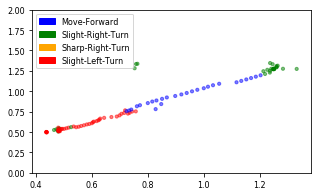

In [4]:
import matplotlib.patches as mpatches
from matplotlib import colors

cmap = colors.ListedColormap(['blue', 'green', 'orange', 'red'])
legend_handles = list()
for i in range(4):
    legend_handles.append(mpatches.Patch(color=cmap(i), label=labels[i]))
plt.legend(handles=legend_handles, loc='upper left')

n = 120 # First 120 points
plt.scatter(X[:,0][0:n], X[:,1][0:n], c=y[0:n], cmap=cmap, alpha=0.5, s=10)
plt.ylim(0,2);

In [40]:
# Helper code
def heatmap(values, xlabel, ylabel, xticklabels, yticklabels, samples=None, cmap=None,
            vmin=None, vmax=None, ax=None, fmt="%0.2f"):
    """
    Plots a heatmap for the performance of a model for every combination of two hyperparameter values,
    as well as a set of selected samples of these
    """
    if ax is None:
        ax = plt.gca()
    ax.figure.set_size_inches(10,10)
    img = ax.pcolor(values, cmap=cmap, vmin=None, vmax=None)
    img.update_scalarmappable()
    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)
    ax.set_xticks(np.arange(len(xticklabels)) + .5)
    ax.set_yticks(np.arange(len(yticklabels)) + .5)
    ax.set_xticklabels(xticklabels)
    ax.set_yticklabels(yticklabels)
    ax.set_aspect(1)
    ax.tick_params(axis='y', labelsize=12)
    ax.tick_params(axis='x', labelsize=12, labelrotation=90)

    if samples is not None:
        for x,y in samples:
            ax.text(x, y, '.', color=w, ha="center", va="center", size=12)
    plt.colorbar(img).set_label('Mean Accuracy',size=12)
    return img

## Landscape analysis
First, let's take a look at what the hyperparameter-performance landscape looks like. Since our model is an SVM with RBF kernel, we are only dealing with two main hyperparameters, $C$ and $\gamma$, so this is easy to visualize. We notice that there is no single optimum, but more like a ridge that trades off C and $\gamma$. This happens because both hyperparameters control the regularization of the model: the higher $C$ and $\gamma$, the more we let the model overfit. If we lower them, we regularize the model. So, if we increase $C$, we have to decrease $\gamma$ to get the same level of regularization. The surface is relatively smooth, but we still must search the space with some care to `find' the optimum. 

In [25]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

svc = SVC(kernel='rbf', random_state=0)
hp_range = np.logspace(-15,15,base=2,num=20)
hyperparams = {'C':hp_range, 'gamma':hp_range}
grid = GridSearchCV(svc,hyperparams,n_jobs=-1).fit(X,y)

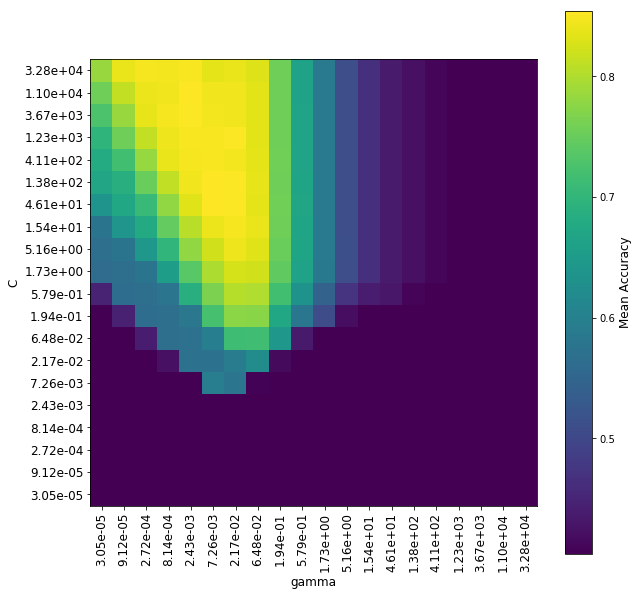

In [41]:
scores = []
for i in range(0,20):
    scores.append(list(grid.cv_results_['mean_test_score'])[i*20:i*20+20])
ticks = ['{:.2e}'.format(x) for x in hp_range]
heatmap(values=scores, xlabel='gamma', ylabel='C', xticklabels=ticks, yticklabels=ticks)
plt.show();

## Multi-fidelity optimization
We will implement a fast optimization technique generally known as _multi-fidelity optimization_. Instead of training the model on all the training data for every hyperparameter configuration, we use the following procedure:

Successive Halving (only look at the top left image):
- collect $n$ random hyperparameter configurations (squares in the image below)
- split the original training data randomly in half, and repeat this $k$ times
- evaluate all hyperparameter configurations on the smallest sample
- select the best 50% of configurations (green squares), and run these on the next larger sample
- repeat until all training data has been used, and return the best of the remaining configuration (white squares)

Obviously, this can lead to suboptimal results, since you may remove a configuration too soon: it may be worse on a small sample but better on a larger sample, i.e. its learning curve may cross and overtake others. A simple solution for this is called [_Hyperband_](https://arxiv.org/pdf/1603.06560.pdf), illustrated below.

Hyperband:
- Do one successive halving run (also called a _bracket_)
- Start a new bracket with an initial sample twice as large, but with only log_3(n) configurations.
- Repeat until you have done this for all subsamples. Return the best overall method.

![Hyperband](hyperband.png)

2_ Implement Successive Halving (3 points)
* Implementing a function that performs a single step as described above
    - Input: data sample, list of input configurations
    - Output: list of selected configurations
    - Print a trace of the best configuration and its accuracy after every step
* Implement the outer loop
    - Input: the complete dataset and list of random configurations
    - Output: the best final configuration and model
* Run the whole procedure using $n=100$ and $k=5$
* Discuss the results. Is this faster/better than a normal grid or random search? Do you still get an improvement in the later runs?

3_ Visualize Successive Halving (2 points)
* For each step, generate a plot with the following:
    - The heatmap as produced in point 1. This requires a complete grid search on the subsample of the data in that step.
    - The selected random configurations superimposed (eg. use white dots/crosses)
* The answer should be a series of 5 of such plots
* Interpret and explain the result. Does it seem like the method is doing anything useful?

4_ Implement Hyperband (3 points)
* Use your previous implementation of successive halving to implement the hyperband method
    * Input: complete dataset and list of random configurations
    * Output: the best configuration and model
    * Print a trace of the best configuration after every bracket (in addition to the trace printed by the successive halving function)
* Discuss the results. Is this faster/better than successive halving? Do you still get an improvement in the later runs?
* Provide a critical discussion on when this method is useful and when it is not.